# Курсовой проект Real Estate Price Prediction

#### Задание для курсового проекта

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

- Сдать проект нужно в течение 7 дней после окончания последнего вебинара.

- Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.

- Необходимо получить R2 > 0.6 на Private Leaderboard.

- Укажите свой ник на kaggle

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к директориям и файлам

In [4]:
DATASET_PATH_train = 'train.csv'

In [5]:
DATASET_PATH_test = 'test.csv'


## 1. Загрузка данных


#### Описание датасета

Data fields:

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Пути к директориям и файлам**

In [7]:
df_train = pd.read_csv(DATASET_PATH_train, sep=',')

In [8]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [9]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [10]:
df_test = pd.read_csv(DATASET_PATH_test, sep=',')

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [12]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Приведение типов

Приведем признаки Id, DistrictId в object, чтобы они не мешали при анализе вещественных признаков. 

In [13]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
print(df_train['Id'].dtype)
print(df_train['DistrictId'].dtype)

object
object


### EDA

#### Обзор целевой переменной

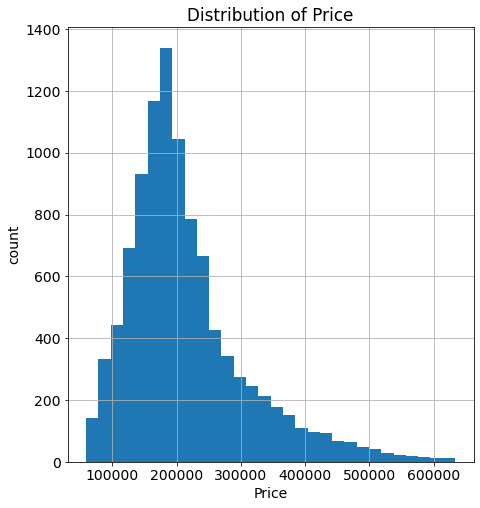

In [14]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['Price'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price')
plt.show()

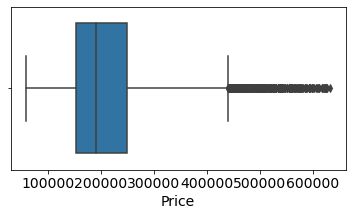

In [15]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Price'], whis=2)

plt.xlabel('Price')
plt.show()

По первому графику можно сказать, что явных выбросов нет, а по усам видно, что больше 440000 данные похожи на выбросы, но это не факт, что выбросы.

##### Обзор номинативных переменных

In [16]:
df_obj = df_train.select_dtypes(include='object')

In [17]:
df_obj

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,11809,27,B,B,B
1,3013,22,B,B,B
2,8215,1,B,B,B
3,2352,1,B,B,B
4,13866,94,B,B,B
...,...,...,...,...,...
9995,1260,61,B,B,B
9996,16265,27,B,B,A
9997,2795,178,B,B,B
9998,14561,21,B,B,B


In [18]:
df_train['Id'].value_counts()

6581     1
10960    1
643      1
5927     1
1013     1
        ..
15952    1
8328     1
10411    1
11479    1
11288    1
Name: Id, Length: 10000, dtype: int64

In [19]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
205      1
209      1
174      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [20]:
df_train['DistrictId'].nunique()

205

In [21]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [22]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [23]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## 2. Обработка выбросов

##### Rooms

In [24]:
df_train['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [25]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Видно, что значения 0 явно выброс, а больше 5 маловероятны.  

In [26]:
df_train[df_train['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798


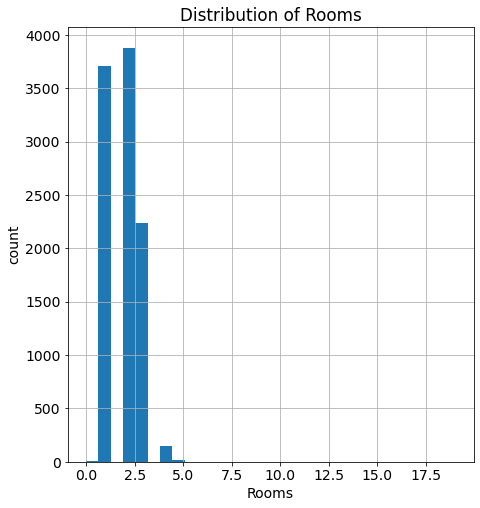

In [27]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['Rooms'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Rooms')

plt.title('Distribution of Rooms')
plt.show()

Создадим новый признак. Все значения, что равны 0 и больше 5, заменим медианой:

In [28]:
df_train['Rooms_outlier'] = 0


In [29]:
df_train.loc[((df_train['Rooms'] == 0) | (df_train['Rooms'] > 5)), 'Rooms_outlier'] = 1

In [30]:
df_train.loc[((df_train['Rooms'] == 0) | (df_train['Rooms'] > 5)), 'Rooms'] = df_train['Rooms'].median()

In [31]:
df_train[df_train['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier


In [32]:
df_train.loc[df_train['Rooms_outlier'] == 1, 'Rooms']

2004    2.0
2194    2.0
2728    2.0
3780    2.0
5894    2.0
6088    2.0
6401    2.0
7644    2.0
7929    2.0
8794    2.0
9767    2.0
9869    2.0
Name: Rooms, dtype: float64

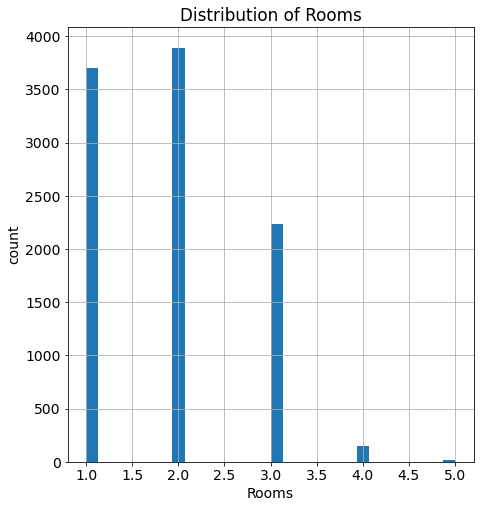

In [33]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['Rooms'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Rooms')

#plt.subplot(122)
#sns.kdeplot(df_train['Price'], shade=True, legend=False)
#plt.xlabel('Price')

plt.title('Distribution of Rooms')
plt.show()

In [34]:
df_train['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [35]:
df_train['Rooms'].describe()

count    10000.000000
mean         1.888400
std          0.811056
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: Rooms, dtype: float64

#### Square:

In [36]:
df_train['Square'].value_counts()

52.327165    1
34.785487    1
45.823093    1
57.607965    1
57.925603    1
            ..
60.776683    1
72.956943    1
51.770111    1
41.843220    1
64.226361    1
Name: Square, Length: 10000, dtype: int64

In [37]:
df_train['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

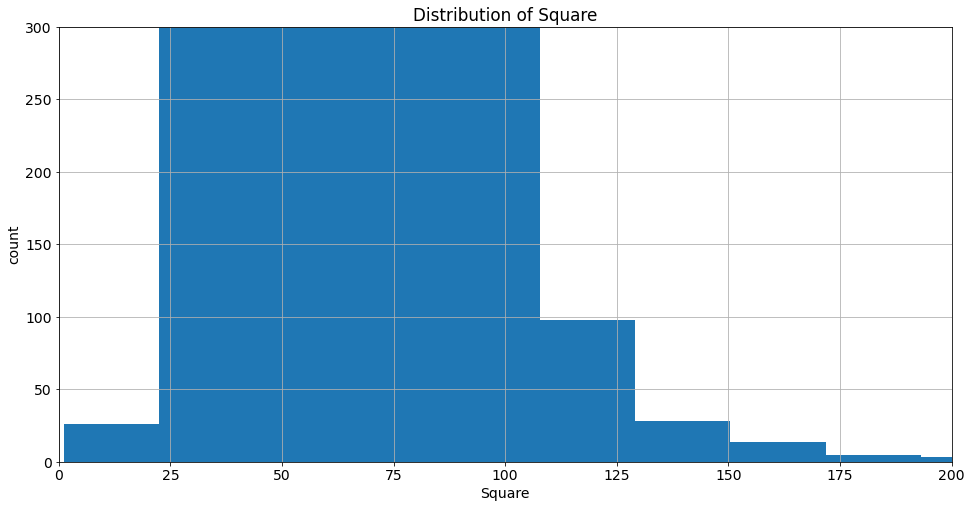

In [38]:
plt.figure(figsize = (16, 8))
plt.axis([0, 200, 0, 300])

#plt.plot(121)
df_train['Square'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Square')

plt.title('Distribution of Square')
plt.show()

Значения < 23 и > 128 похожи на выбросы. Заменим их на медиану.

In [39]:
df_train['Square_outlier'] = 0

In [40]:
df_train.loc[((df_train['Square'] < 23) | (df_train['Square'] > 128)), 'Square_outlier'] = 1

In [41]:
df_train.loc[((df_train['Square'] < 23) | (df_train['Square'] > 128)), 'Square'] = df_train['Square'].median()

In [42]:
df_train.loc[((df_train['Square'] < 23) | (df_train['Square'] > 128))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier


In [43]:
df_train['Square'].describe()

count    10000.000000
mean        55.751411
std         17.514976
min         23.015919
25%         41.837707
50%         52.513310
75%         65.680737
max        127.651237
Name: Square, dtype: float64

#### KitchenSquare

In [44]:
df_train['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [45]:
df_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

Найдем квантиль для макс значения:

In [46]:
df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

К выбросам можно принять значения меньше 5 (4, 3 не часто встречаются и для этого параметра очень маленькие), больше 13 и заменить их на медиану.

In [47]:
df_train['KitchenSquare_outlier'] = 0

In [48]:
df_train.loc[((df_train['KitchenSquare'] < 5) | (df_train['KitchenSquare'] > 13)), 'KitchenSquare_outlier'] = 1

In [49]:
df_train['KitchenSquare_outlier'].value_counts()

0    6589
1    3411
Name: KitchenSquare_outlier, dtype: int64

In [50]:
df_train.loc[((df_train['KitchenSquare'] < 5) | (df_train['KitchenSquare'] > 13)), 'KitchenSquare'] = df_train['KitchenSquare'].median()

In [51]:
df_train['KitchenSquare'].value_counts()

6.0     4449
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

#### LifeSquare

In [52]:
df_train['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [53]:
df_train['LifeSquare'].value_counts()

20.151696    1
28.241964    1
23.884805    1
51.826876    1
47.972602    1
            ..
45.455722    1
50.458505    1
42.172028    1
21.993610    1
27.598712    1
Name: LifeSquare, Length: 7887, dtype: int64

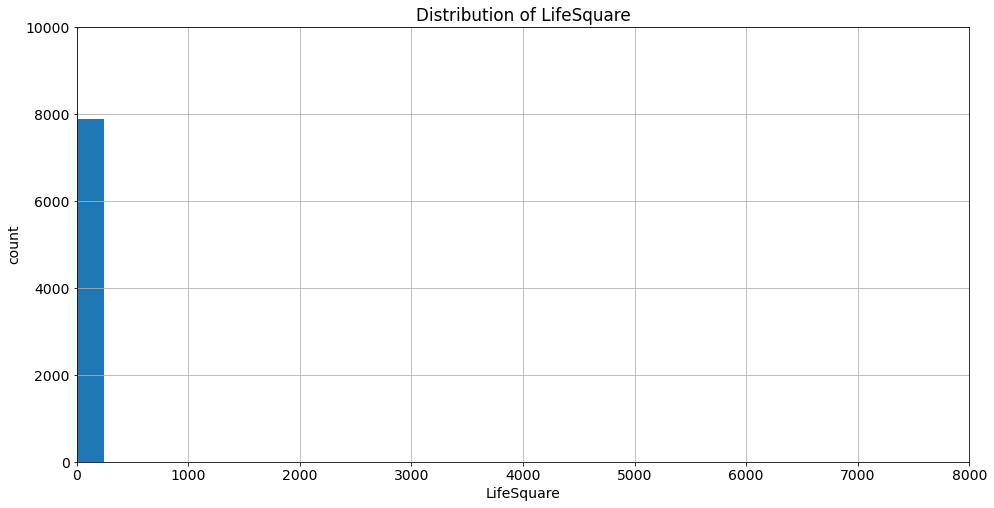

In [54]:
plt.figure(figsize = (16, 8))
plt.axis([0, 8000, 0, 10000])

#plt.plot(121)
df_train['LifeSquare'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('LifeSquare')


#plt.subplot(122)
#sns.kdeplot(df_train['Price'], shade=True, legend=False)
#plt.xlabel('Price')

plt.title('Distribution of LifeSquare')
plt.show()

Посмотрим на квантиль мин и макс:

In [55]:
df_train['LifeSquare'].quantile(.975), df_train['LifeSquare'].quantile(.025)

(80.74810407514713, 5.914129735023812)

Можно возпользоваться квантилей, либо взять показатели увеличенные, так как жилая площадь м.б. больше 81 и 6.

(при значении 81 модель показывает приблизительно одинаковый покзатель R2 = 0.768-0.772, что и при 110, но где-то даже выше. Скорее всего, лучше было воспользоваться квантилью)

In [56]:
df_train['LifeSquare_outlier'] = 0

In [57]:
df_train.loc[((df_train['LifeSquare'] <= 12) | (df_train['LifeSquare'] > 110)), 'LifeSquare_outlier'] = 1

In [58]:
df_train.loc[((df_train['LifeSquare'] <= 12) | (df_train['LifeSquare'] > 110)), 'LifeSquare'] = df_train['LifeSquare'].median()

In [59]:
df_train.loc[((df_train['KitchenSquare'] + df_train['LifeSquare']) > df_train['Square']), 'LifeSquare_outlier'] = 1

In [60]:
df_train.loc[((df_train['KitchenSquare'] + df_train['LifeSquare']) > df_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier
8,9951,1,1.0,46.887892,44.628132,6.0,12,20.0,1977,0.007122,...,0,NaN,0,1,B,160400.401732,0,0,1,1
9,8094,6,3.0,79.867477,75.085125,6.0,3,17.0,2014,0.243205,...,0,540.0,0,0,B,194756.023945,0,0,1,1
19,367,45,1.0,42.367289,40.012529,6.0,16,14.0,2015,0.195781,...,6,NaN,3,2,B,250466.980777,0,0,1,1
33,847,74,2.0,73.314975,74.131261,6.0,7,6.0,1977,0.075779,...,3,NaN,0,2,B,254005.381863,0,0,1,1
34,7757,27,2.0,58.783661,55.441256,11.0,13,12.0,1977,0.011654,...,0,NaN,0,0,B,138396.984612,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9965,6441,52,3.0,85.796885,85.305246,6.0,15,17.0,1977,0.371149,...,1,750.0,2,5,B,204462.983720,0,0,1,1
9979,2201,6,1.0,40.043234,41.984322,6.0,3,17.0,2014,0.243205,...,0,540.0,0,0,B,134888.083598,0,0,1,1
9982,10268,27,1.0,36.112393,32.781260,6.0,9,16.0,1977,0.211401,...,0,NaN,0,1,B,94881.691800,0,0,1,1
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,...,0,NaN,0,1,B,203908.192698,0,0,0,1


Так же можно увидеть, что если сложить показатели KitchenSquare и LifeSquare, то они м.б. больше Square, что явно указывает на выброс.
Обработаем такие значения и присвоим таким значениям 1.6 от общей площади:

In [61]:
df_train.loc[((df_train['KitchenSquare'] + df_train['LifeSquare']) > df_train['Square']), 'LifeSquare_outlier'] = 1

In [62]:
condition_LS = ((df_train['KitchenSquare'] + df_train['LifeSquare']) > df_train['Square'])

In [63]:
df_train.loc[condition_LS, 'LifeSquare'] = df_train.loc[condition_LS, 'Square'] / 1.6

Наблюдаются также выбросы, где KitchenSquare + LifeSquare + 5 больше общей площади. Обработаем их:

In [64]:
df_train.loc[(((df_train['KitchenSquare'] + df_train['LifeSquare']) + 5) > df_train['Square']), 'LifeSquare_outlier'] = 1

In [65]:
condition_LS_2 = ((df_train['KitchenSquare'] + df_train['LifeSquare'] + 5) > df_train['Square'])

In [66]:
df_train.loc[condition_LS_2, 'LifeSquare'] = df_train.loc[condition_LS_2, 'Square'] - df_train.loc[condition_LS_2, 'KitchenSquare'] - 5

In [67]:
df_train.loc[((df_train['KitchenSquare'] + df_train['LifeSquare']) > df_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier


In [68]:
df_train.loc[(((df_train['KitchenSquare'] + df_train['LifeSquare']) + 5) > df_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier


In [69]:
df_train['LifeSquare_outlier'].value_counts()

0    8351
1    1649
Name: LifeSquare_outlier, dtype: int64

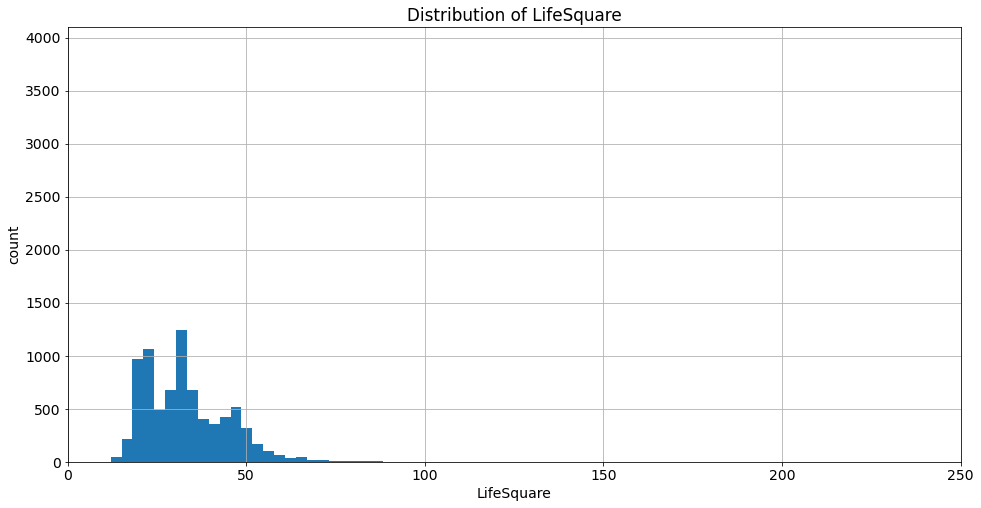

In [70]:
plt.figure(figsize = (16, 8))
plt.axis([0, 250, 0, 4100])

#plt.plot(121)
df_train['LifeSquare'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('LifeSquare')


#plt.subplot(122)
#sns.kdeplot(df_train['Price'], shade=True, legend=False)
#plt.xlabel('Price')

plt.title('Distribution of LifeSquare')
plt.show()

In [71]:
df_train['LifeSquare'].describe()

count    7887.000000
mean       33.090030
std        11.578485
min        12.015919
25%        23.059839
50%        31.806552
75%        40.676636
max       103.637322
Name: LifeSquare, dtype: float64

#### Floor и HouseFloor

In [72]:
df_train['Floor'].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [73]:
df_train['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
37      1
33      1
31      1
Name: Floor, dtype: int64

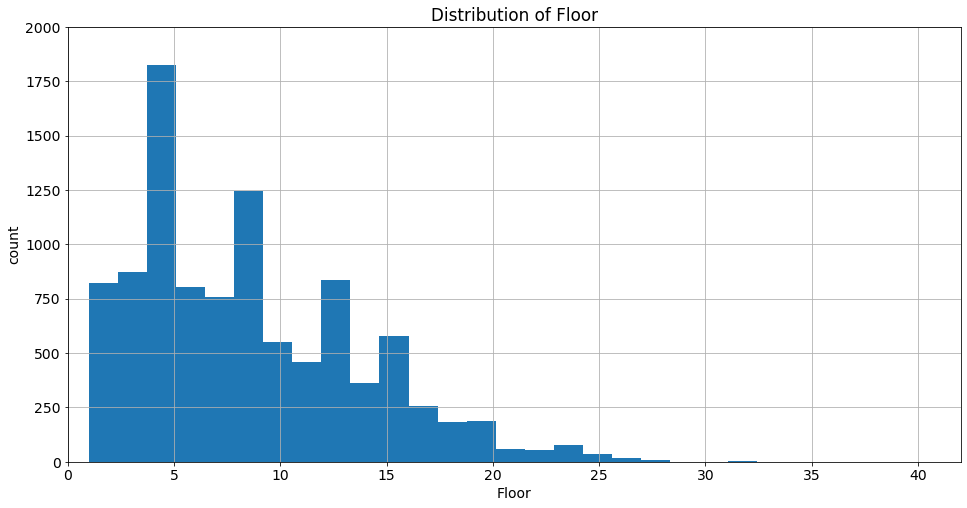

In [74]:
plt.figure(figsize = (16, 8))
plt.axis([0, 42, 0, 2000])

df_train['Floor'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Floor')

plt.title('Distribution of Floor')
plt.show()

Явных выбросов не наблюдается.

In [75]:
df_train['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [76]:
df_train['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
39.0        2
48.0        2
99.0        2
29.0        1
44.0        1
47.0        1
36.0        1
31.0        1
38.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

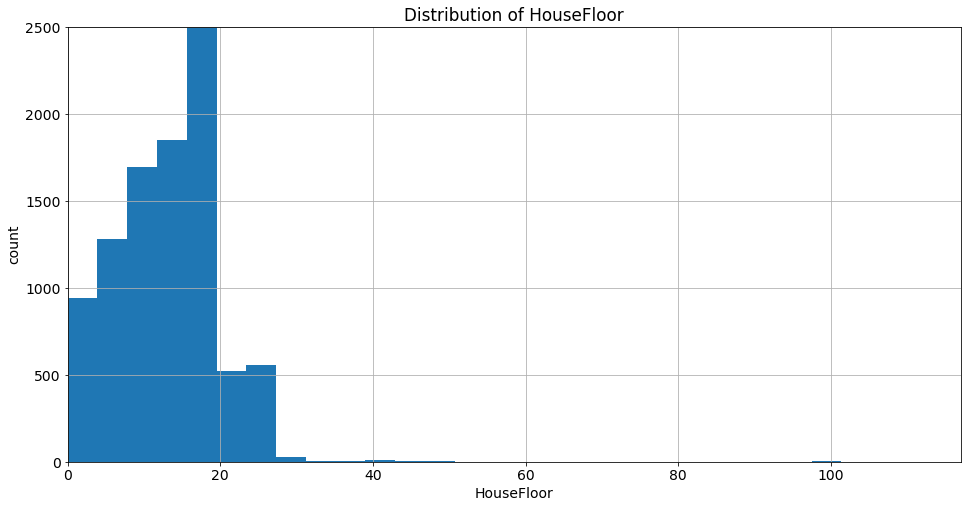

In [77]:
plt.figure(figsize = (16, 8))
plt.axis([0, 117, 0, 2500])

df_train['HouseFloor'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('HouseFloor')


plt.title('Distribution of HouseFloor')
plt.show()

Значения, равные 0 и больше 96, являются выбросами. Заполним их медианой.

In [78]:
df_train['HouseFloor_outlier'] = 0

In [79]:
df_train.loc[((df_train['HouseFloor'] == 0) | (df_train['HouseFloor'] > 96)), 'HouseFloor_outlier'] = 1

In [80]:
df_train['HouseFloor_outlier'].value_counts()

0    9728
1     272
Name: HouseFloor_outlier, dtype: int64

In [81]:
df_train.loc[((df_train['HouseFloor'] == 0) | (df_train['HouseFloor'] > 95)), 'HouseFloor'] = df_train['HouseFloor'].median()

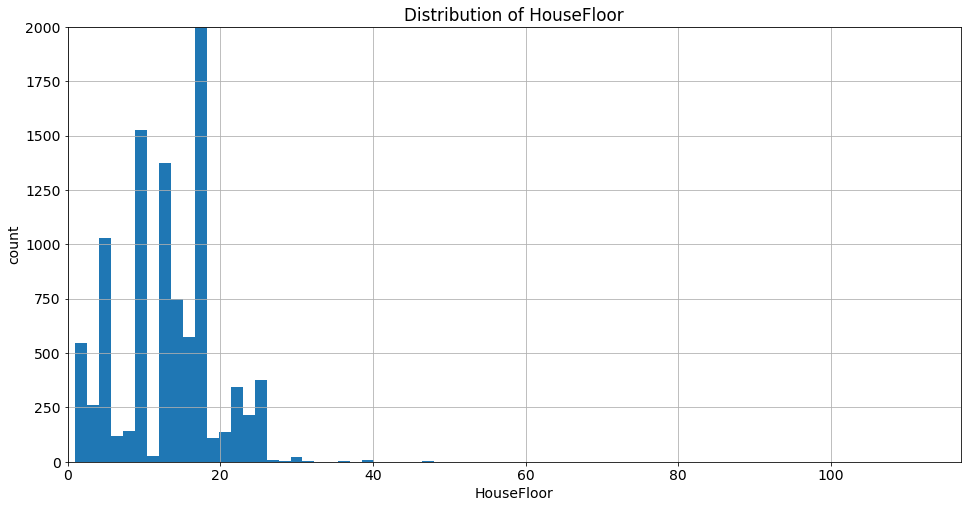

In [82]:
plt.figure(figsize = (16, 8))
plt.axis([0, 117, 0, 2000])

df_train['HouseFloor'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('HouseFloor')

plt.title('Distribution of HouseFloor')
plt.show()

Также выброасми будут значения, при которых Floor > HouseFloor. Заполним эти значения:

In [83]:
df_train.loc[(df_train['Floor'] > df_train['HouseFloor']), 'HouseFloor_outlier'] = 1

In [84]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

1610

In [85]:
floor_val = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index

In [86]:
floor_val

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [87]:
df_train.loc[floor_val, 'Floor'] = df_train.loc[floor_val, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [88]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

0

#### HouseYear

In [89]:
df_train['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [90]:
df_train['HouseYear_outlier'] = 0

In [91]:
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear_outlier'] = 1

In [92]:
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = 2020

In [93]:
df_train['HouseYear_outlier'].value_counts()

0    9998
1       2
Name: HouseYear_outlier, dtype: int64

Либо воспользуемся datetime:

In [94]:
 #current_year = datetime.now().year
 #df_train['HouseYear_outlier'] = 0
 #df_train.loc[df_train['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
 #df_train.loc[df_train['HouseYear'] > current_year, 'HouseYear'] = current_year

#### Ecology_1

In [95]:
df_train['Ecology_1'].describe()

count    10000.000000
mean         0.118858
std          0.119025
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

In [96]:
df_train['Ecology_1'].value_counts(ascending=True)

0.012522      1
0.014334      1
0.394094      2
0.011320      3
0.386772      6
           ... 
0.075779    346
0.072158    486
0.243205    511
0.000000    537
0.007122    587
Name: Ecology_1, Length: 129, dtype: int64

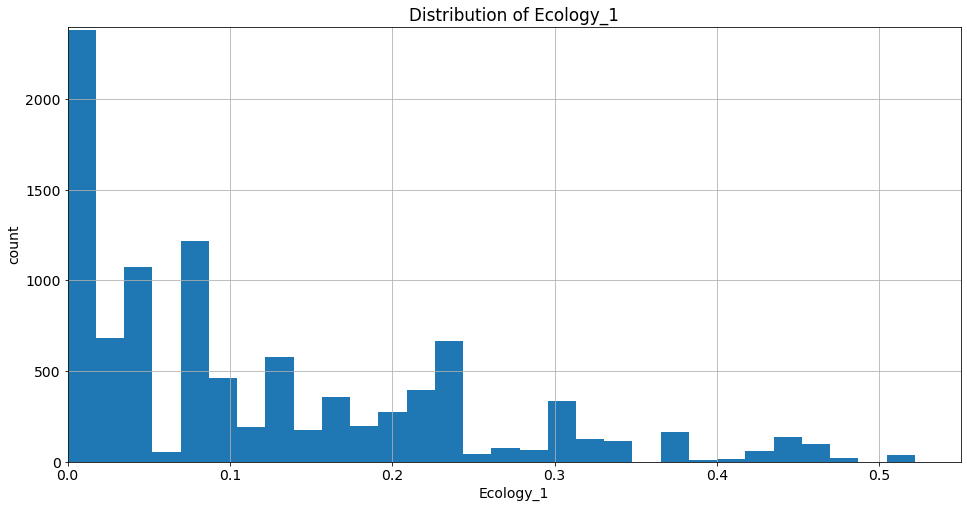

In [97]:
plt.figure(figsize = (16, 8))
plt.axis([0, 0.55, 0, 2400])

df_train['Ecology_1'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Ecology_1')

plt.title('Distribution of Ecology_1')
plt.show()

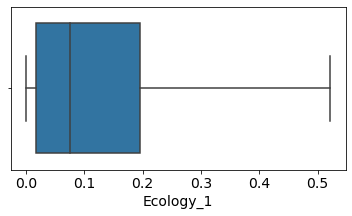

In [98]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Ecology_1'], whis=2)

plt.xlabel('Ecology_1')
plt.show()

Явных выбросов не выявлено.

## Social_1	Social_2 Social_3

In [99]:
df_train['Social_1'].describe()

count    10000.000000
mean        24.687000
std         17.532614
min          0.000000
25%          6.000000
50%         25.000000
75%         36.000000
max         74.000000
Name: Social_1, dtype: float64

In [100]:
df_train['Social_1'].value_counts(ascending=True)

3       9
7      15
12     18
13     22
10     24
14     46
20     50
15     51
8      62
38     64
29     70
50     79
41     83
32     87
18     92
49     95
17     96
66     99
19    118
16    123
26    127
42    129
11    138
4     141
28    144
27    151
39    159
74    176
47    177
35    200
0     201
52    201
24    205
37    205
21    207
36    209
9     213
43    238
31    243
46    245
33    252
34    311
53    355
22    367
6     377
23    434
30    465
5     528
25    557
1     654
2     688
Name: Social_1, dtype: int64

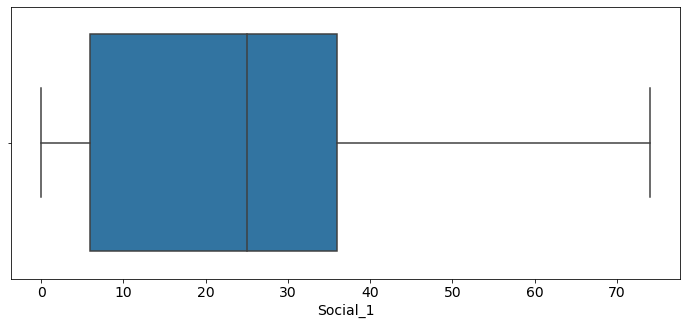

In [101]:
plt.figure(figsize=(12, 5))

sns.boxplot(df_train['Social_1'], whis=2)

plt.xlabel('Social_1')
plt.show()

Явных выбросов не выявлено.

In [102]:
df_train['Social_2'].describe()

count    10000.000000
mean      5352.157400
std       4006.799803
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

In [103]:
df_train['Social_2'].value_counts(ascending=False)

264     587
1564    511
629     486
1437    346
6398    245
       ... 
1423      3
568       3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

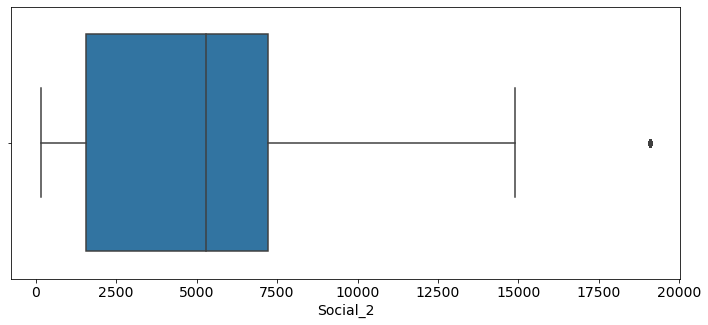

In [104]:
plt.figure(figsize=(12, 5))

sns.boxplot(df_train['Social_2'], whis=2)

plt.xlabel('Social_2')
plt.show()

Можно посчитать за выбросы значения больше 14900, но при этом модель показывает значения хуже.

In [105]:
df_train['Social_3'].describe()

count    10000.000000
mean         8.039200
std         23.831875
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

In [106]:
df_train['Social_3'].value_counts(ascending=False)

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
93       25
59       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

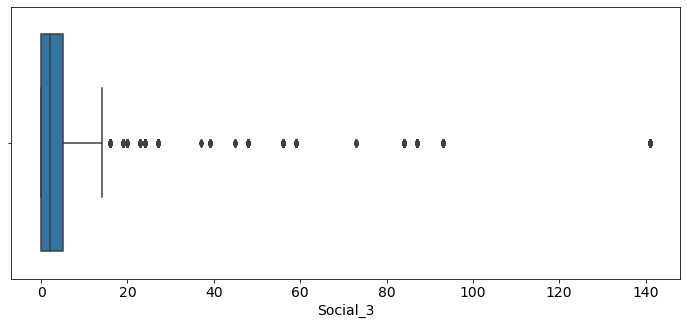

In [107]:
plt.figure(figsize=(12, 5))

sns.boxplot(df_train['Social_3'], whis=2)

plt.xlabel('Social_3')
plt.show()

Можно посчитать за выбросы значения больше 16, но при этом модель показывает значения хуже.

## Helthcare_2

In [108]:
df_train['Helthcare_2'].describe()

count    10000.000000
mean         1.319500
std          1.493601
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: Helthcare_2, dtype: float64

In [109]:
df_train['Helthcare_2'].value_counts(ascending=False)

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

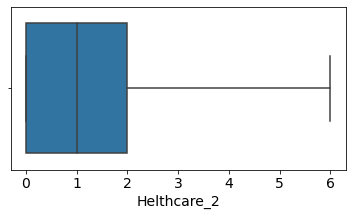

In [110]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Helthcare_2'], whis=2)

plt.xlabel('Helthcare_2')
plt.show()

Явных выбросов не выявлено.

## Shops_1

In [111]:
df_train['Shops_1'].describe()

count    10000.000000
mean         4.231300
std          4.806341
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         23.000000
Name: Shops_1, dtype: float64

In [112]:
df_train['Shops_1'].value_counts(ascending=False)

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

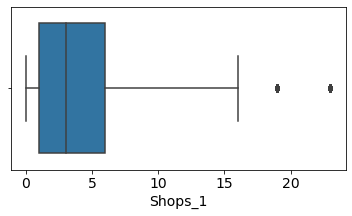

In [113]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Shops_1'], whis=2)

plt.xlabel('Shops_1')
plt.show()

Можно посчитать за выбросы значения больше 16, но при этом модель показывает значения хуже.

## 3. Обработка пропусков

In [114]:
df_train.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare               2113
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
Square_outlier              0
KitchenSquare_outlier       0
LifeSquare_outlier          0
HouseFloor_outlier          0
HouseYear_outlier           0
dtype: int64

In [115]:
df_train['LifeSquare_nan'] = 0
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,B,305018.871089,0,0,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,B,177734.553407,0,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,B,282078.720850,0,0,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,6.0,10,22.0,1977,0.007122,...,1,B,168106.007630,0,0,1,0,0,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,B,343995.102962,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,9,B,119367.455796,0,0,0,0,0,0,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,0,A,199715.148807,0,0,0,0,1,0,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,5,B,165953.912580,0,0,0,0,0,0,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,5,B,171842.411855,0,0,0,0,0,0,0


In [116]:
df_train.loc[(df_train['LifeSquare'].isna()), 'LifeSquare_nan']

0       0
3       0
18      0
20      0
24      0
       ..
9975    0
9978    0
9981    0
9983    0
9991    0
Name: LifeSquare_nan, Length: 2113, dtype: int64

In [117]:
df_train.loc[(df_train['LifeSquare'].isna()), 'LifeSquare_nan'] = 1

In [118]:
df_train['LifeSquare_nan'].value_counts()

0    7887
1    2113
Name: LifeSquare_nan, dtype: int64

In [119]:
condition_LS_3 = (df_train['LifeSquare'].isna()) & (~df_train['Square'].isna())

In [120]:
condition_LS.value_counts()

False    8803
True     1197
dtype: int64

In [121]:
df_train.loc[condition_LS_3, 'LifeSquare'] = df_train.loc[condition_LS_3, 'Square'] / 1.6

In [122]:
df_train['LifeSquare'].describe()

count    10000.000000
mean        33.918550
std         11.562191
min         12.015919
25%         24.473143
50%         32.447405
75%         41.362493
max        103.637322
Name: LifeSquare, dtype: float64

## Healthcare_1

In [123]:
df_train.drop('Healthcare_1', axis=1, inplace=True)

Создадим класс DataPreprocessing и внесем все преобразования, полученные ранее.

In [124]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
                
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
            
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms'] = self.medians['Rooms']
        
        # Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < 23) | (X['Square'] > 128), 'Square_outlier'] = 1
        X.loc[(X['Square'] < 23) | (X['Square'] > 128), 'Square'] = self.medians['Square']
        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 5) | (X['KitchenSquare'] > 13), 'KitchenSquare_outlier'] = 1
        X.loc[(X['KitchenSquare'] < 5) | (X['KitchenSquare'] > 13), 'KitchenSquare'] = self.medians['KitchenSquare']
        
         # LifeSquare
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'] <= 12) | (X['LifeSquare'] > 110), 'LifeSquare_outlier'] = 1
        X.loc[(X['LifeSquare'] <= 12) | (X['LifeSquare'] > 110), 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[((X['KitchenSquare'] + X['LifeSquare']) > X['Square']), 'LifeSquare_outlier'] = 1
        condition_LS = ((X['KitchenSquare'] + X['LifeSquare']) > X['Square'])
        X.loc[condition_LS, 'LifeSquare'] = X.loc[condition_LS, 'Square'] / 1.6
        X.loc[(((X['KitchenSquare'] + X['LifeSquare']) + 5) > X['Square']), 'LifeSquare_outlier'] = 1
        condition_LS_2 = ((X['KitchenSquare'] + X['LifeSquare'] + 5) > X['Square'])
        X.loc[condition_LS_2, 'LifeSquare'] = X.loc[condition_LS_2, 'Square'] - X.loc[condition_LS_2, 'KitchenSquare'] - 5
        X['LifeSquare_nan'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        condition_LS_3 = (X['LifeSquare'].isna()) & (~X['Square'].isna())
        X.loc[condition_LS_3, 'LifeSquare'] = X.loc[condition_LS_3, 'Square'] / 1.6
        
         # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 96), 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 96), 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_val = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_val, 'Floor'] = X.loc[floor_val, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        
        # Helthcare_2
        X['Helthcare_2_outlier'] = 0
        X.loc[X['Helthcare_2'] > 3, 'Helthcare_2_outlier'] = 1
        X.loc[X['Helthcare_2'] > 3, 'Helthcare_2'] = self.medians['Helthcare_2']

        X.fillna(self.medians, inplace=True)
        
        return X

## 4. Построение новых признаков

#### Дамми переменные:

In [125]:
df_train_bin_features = {'A' : 0, 'B' : 1}

In [126]:
df_train['Ecology_2'] = df_train['Ecology_2'].replace(df_train_bin_features)

In [127]:
df_train['Ecology_3'] = df_train['Ecology_3'].replace(df_train_bin_features)

In [128]:
df_train['Shops_2'] = df_train['Shops_2'].replace(df_train_bin_features)

In [129]:
df_train['Ecology_2'].value_counts()

1    9903
0      97
Name: Ecology_2, dtype: int64

### Построим корреляционную матрицу

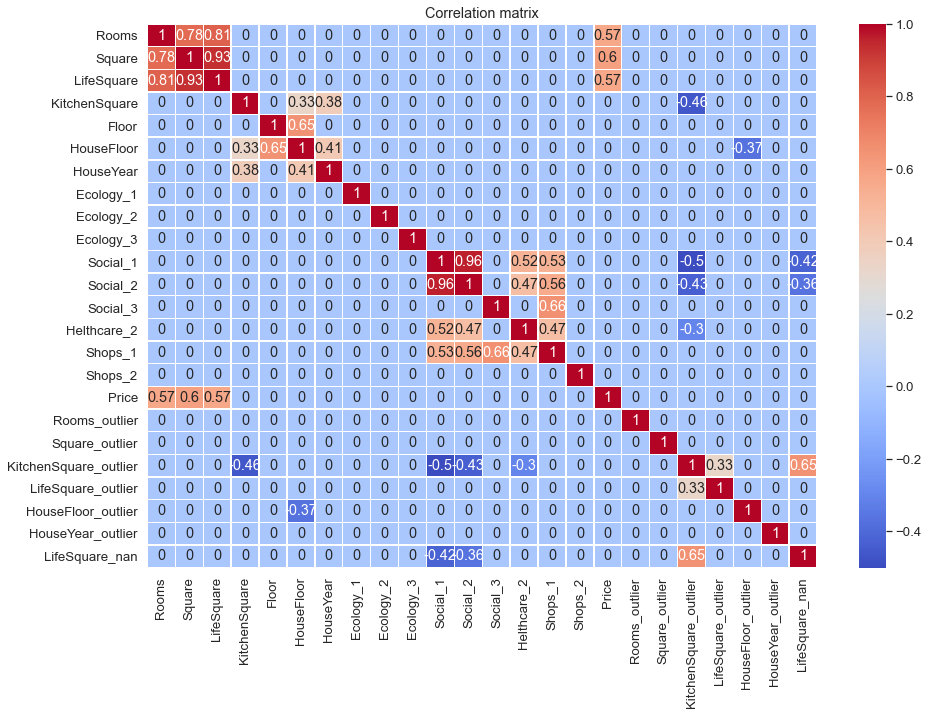

In [130]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.2)

# вызываем метод corr у датафрейма:
corr_matrix = df_train.corr()
# округляем до двух знаков
corr_matrix = np.round(corr_matrix, 2)
# наша корреляция не слишком большая, стремится к нулю, 
# такие корреляции зануляем и отриц и полож значения abs
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

# отрисуем в heatmap
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### ByFloorYearPrice

Найдем зависимость от года дома, этажа и цены.

In [131]:
def age_to_cat(X):
    bins = [0, 1980, 1990, 2000, 2015, X['HouseYear'].max()]
    X['age_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['age_cat'].fillna(-1, inplace=True)
    return X

In [132]:
df_train = age_to_cat(df_train)

In [133]:
def floor_to_cat(X):
    bins = [0, 6, 9, 20, 30, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

In [134]:
df_train = floor_to_cat(df_train)

In [135]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,age_cat,floor_cat
0,11809,27,3.0,115.027311,71.892069,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,0,0,0,0,1,3,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,0,0,0,0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,0,0,0,1,0
3,2352,1,1.0,40.409907,25.256192,6.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,0,0,0,1,0,2
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,0,0,0,0,0,2


In [136]:
By_Floor_Year_Price = df_train.groupby(['age_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'ByFloorYearPrice'})

In [137]:
By_Floor_Year_Price.head()

,age_cat,floor_cat,ByFloorYearPrice
0,0,0,184312.691552
1,0,1,194067.611300
2,0,2,180990.881881
3,0,3,186942.209779
4,0,4,391676.797636


In [138]:
df_train['floor_cat'].value_counts()

0    5119
2    2761
1    1957
3     157
4       6
Name: floor_cat, dtype: int64

In [139]:
df_train = df_train.merge(By_Floor_Year_Price, on=['age_cat', 'floor_cat'], how='left')

In [140]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,age_cat,floor_cat,ByFloorYearPrice
0,11809,27,3.0,115.027311,71.892069,10.0,4,10.0,2014,0.075424,...,0,0,0,0,0,0,1,3,0,195089.174745
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,0,0,0,1,194067.611300
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,0,0,1,0,211955.491385
3,2352,1,1.0,40.409907,25.256192,6.0,10,22.0,1977,0.007122,...,0,0,1,0,0,0,1,0,2,180990.881881
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,0,0,0,2,180990.881881


##### DistrictSize

In [141]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [142]:
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [143]:
df_train = df_train.merge(district_size, on='DistrictId', how='left')

In [144]:
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,age_cat,floor_cat,ByFloorYearPrice,DistrictSize
0,11809,27,3.0,115.027311,71.892069,10.0,4,10.0,2014,0.075424,...,0,0,0,0,0,1,3,0,195089.174745,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,0,0,1,194067.611300,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,0,1,0,211955.491385,652
3,2352,1,1.0,40.409907,25.256192,6.0,10,22.0,1977,0.007122,...,0,1,0,0,0,1,0,2,180990.881881,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,0,0,2,180990.881881,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,0,0,0,0,0,0,1,0,211955.491385,118
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,0,0,0,1,0,0,0,2,180990.881881,851
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,0,0,0,0,0,0,0,0,184312.691552,7
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,0,0,0,0,0,0,0,0,184312.691552,165


#### By_Shops_Social_Price

Видно по корреляционной матрице хорошую зависимость Shops_1 и Social_1. Создадим новый признак от Price.

In [145]:
By_Shops_Social_Price = df_train.groupby(['Shops_1', 'Social_1'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'ByShopsSocialPrice'})

In [146]:
df_train = df_train.merge(By_Shops_Social_Price, on=['Shops_1', 'Social_1'], how='left')

#### ByHelthcare2Social1Price

Также хорошо прослеживается по корреляционной матрице зависимость Helthcare_2 и Social_1. Создадим новый признак от Price.

In [147]:
By_Helthcare2_Social1_Price = df_train.groupby(['Helthcare_2', 'Social_1'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'ByHelthcare2Social1Price'})

In [148]:
df_train = df_train.merge(By_Helthcare2_Social1_Price, on=['Helthcare_2', 'Social_1'], how='left')

In [149]:
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,age_cat,floor_cat,ByFloorYearPrice,DistrictSize,ByShopsSocialPrice,ByHelthcare2Social1Price
0,11809,27,3.0,115.027311,71.892069,10.0,4,10.0,2014,0.075424,...,0,0,0,1,3,0,195089.174745,851,158578.239161,155389.000353
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,1,194067.611300,78,186161.900526,186809.604691
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,1,0,211955.491385,652,205993.377137,205993.377137
3,2352,1,1.0,40.409907,25.256192,6.0,10,22.0,1977,0.007122,...,0,0,0,1,0,2,180990.881881,652,183882.806975,175732.068626
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,2,180990.881881,89,203153.518639,209395.368656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,0,0,0,0,1,0,211955.491385,118,223982.521830,230395.351017
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,0,1,0,0,0,2,180990.881881,851,161357.589813,161357.589813
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,0,0,0,0,0,0,184312.691552,7,244852.013738,296062.000206
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,0,0,0,0,0,0,184312.691552,165,192744.316827,192744.316827


Создадим класс FeatureGenetator и включим все прежние преобразования в него.

In [150]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.df_train_bin_features = None
        self.By_Floor_Year_Price = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.By_Shops_Social_Price = None
        
        self.By_Helthcare2_Social1_Price = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.df_train_bin_features = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        # Target encoding
        df = X.copy()
        
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.age_to_cat(df)
            self.By_Floor_Year_Price = df.groupby(['age_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'ByFloorYearPrice'})
            self.By_Floor_Year_Price_median = self.By_Floor_Year_Price['ByFloorYearPrice'].median()
        
        # Target encoding
        ## Shops_1, Social_1
        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            self.By_Shops_Social_Price = df.groupby(['Shops_1', 'Social_1'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'ByShopsSocialPrice'})
            self.By_Shops_Social_Price_median = self.By_Shops_Social_Price['ByShopsSocialPrice'].median()

            
        # Target encoding
        ## Helthcare_2, Social_1
        df = X.copy()
        if y is not None:
            df['Price'] = y.values
            self.By_Helthcare2_Social1_Price = df.groupby(['Helthcare_2', 'Social_1'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'ByHelthcare2Social1Price'})
            self.By_Helthcare2_Social1_Price_median = self.By_Helthcare2_Social1_Price['ByHelthcare2Social1Price'].median()
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.df_train_bin_features)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.df_train_bin_features)
        X['Shops_2'] = X['Shops_2'].map(self.df_train_bin_features)
        
        # DistrictId
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.age_to_cat(X)   # + столбец age_cat
        
        # Target encoding
                    
        if self.By_Floor_Year_Price is not None:
            X = X.merge(self.By_Floor_Year_Price, on=['age_cat', 'floor_cat'], how='left')
            X['ByFloorYearPrice'].fillna(self.By_Floor_Year_Price_median, inplace=True)
        
        if self.By_Shops_Social_Price is not None:
            X = X.merge(self.By_Shops_Social_Price, on=['Shops_1', 'Social_1'], how='left')
            X['ByShopsSocialPrice'].fillna(self.By_Shops_Social_Price_median, inplace=True)
        
        if self.By_Helthcare2_Social1_Price is not None:
            X = X.merge(self.By_Helthcare2_Social1_Price, on=['Helthcare_2', 'Social_1'], how='left')
            X['ByHelthcare2Social1Price'].fillna(self.By_Helthcare2_Social1_Price_median, inplace=True)
        
        return X
    
    def age_to_cat(self, X):
        bins = [0, 1980, 1990, 2000, 2015, self.house_year_max]
        X['age_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
        X['age_cat'].fillna(-1, inplace=True)
       
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 6, 9, 20, 30, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X

### 5. Отбор признаков

In [151]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'KitchenSquare_outlier',
 'LifeSquare_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'age_cat',
 'floor_cat',
 'ByFloorYearPrice',
 'DistrictSize',
 'ByShopsSocialPrice',
 'ByHelthcare2Social1Price']

In [152]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'Square_outlier', 'KitchenSquare_outlier', 'LifeSquare_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'Helthcare_2_outlier', 
                     'LifeSquare_nan', 'ByFloorYearPrice', 'DistrictSize', 'ByShopsSocialPrice', 'ByHelthcare2Social1Price']

target_name = 'Price'

### 6. Разбиение на train и test

In [153]:
df_train = pd.read_csv(DATASET_PATH_train)
df_test = pd.read_csv(DATASET_PATH_test)

X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [154]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [155]:
X_train.shape, X_valid.shape, df_test.shape

((6700, 19), (3300, 19), (5000, 19))

In [156]:
data_preprocessor = DataPreprocessing()
data_preprocessor.fit(X_train)

In [157]:
X_train = data_preprocessor.transform(X_train)

In [158]:
X_valid = data_preprocessor.transform(X_valid)

In [159]:
df_test = data_preprocessor.transform(df_test)

In [160]:
X_train.shape, X_valid.shape, df_test.shape

((6700, 26), (3300, 26), (5000, 26))

In [161]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 33), (3300, 33), (5000, 33))

In [162]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

In [163]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [164]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [165]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rooms                     5000 non-null   float64
 1   Square                    5000 non-null   float64
 2   LifeSquare                5000 non-null   float64
 3   KitchenSquare             5000 non-null   float64
 4   Floor                     5000 non-null   int64  
 5   HouseFloor                5000 non-null   float64
 6   HouseYear                 5000 non-null   int64  
 7   Ecology_1                 5000 non-null   float64
 8   Ecology_2                 5000 non-null   int64  
 9   Ecology_3                 5000 non-null   int64  
 10  Social_1                  5000 non-null   int64  
 11  Social_2                  5000 non-null   int64  
 12  Social_3                  5000 non-null   int64  
 13  Helthcare_2               5000 non-null   float64
 14  Shops_1 

## 7. Построение модели

#### Обучение

#### Модель с лучшей метриков R2:

In [166]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [167]:
gbr_model = GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=10,
                                     random_state=21
                                     )

In [168]:
%%time
params = {'n_estimators':[113],
          'max_depth':[6]}
 GridSearchCV - поиск по сетке с кроссвалидацией
gs = GridSearchCV(gbr_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=6,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21,
                           shuffle=True), # перемешивание
                  n_jobs=-1               # модели будут обучаться на всех свободных потоках
                  )
gs.fit(X_train, y_train)

Wall time: 1min 47s


GridSearchCV(cv=KFold(n_splits=6, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=21),
             n_jobs=-1,
             param_grid={'max_depth': [6],
                         'n_estimators': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134])},
             scoring='r2')

In [169]:
gs.best_params_

{'max_depth': 6, 'n_estimators': 113}

In [170]:
gs.best_score_

0.7273168390872987

In [186]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=6,
                                        min_samples_leaf=10,
                                        random_state=21,
                                        n_estimators=113)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=10,
                          n_estimators=113, random_state=21)

#### Оценка модели

Train R2:	0.884
Test R2:	0.772


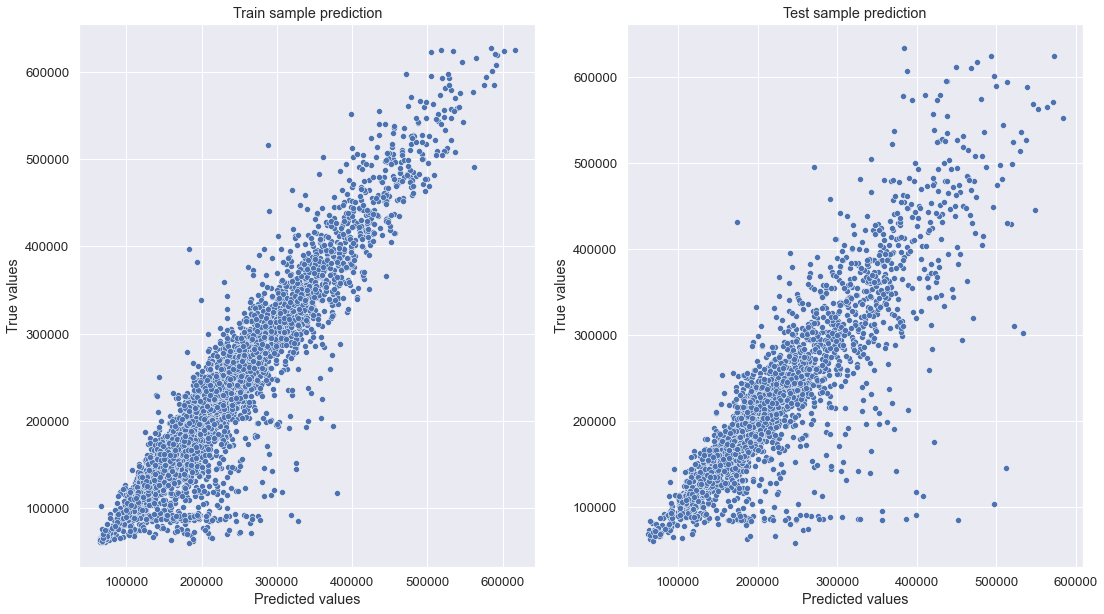

In [187]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [173]:
cv_score = cross_val_score(final_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.74024163, 0.71371988, 0.72603673])

In [174]:
cv_score.mean()

0.7266660810293283

#### Важность признаков

In [175]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.428993
26,ByShopsSocialPrice,0.278075
25,DistrictSize,0.055731
0,Rooms,0.035379
12,Social_3,0.029783
27,ByHelthcare2Social1Price,0.027487
6,HouseYear,0.025824
2,LifeSquare,0.025534
7,Ecology_1,0.014549
5,HouseFloor,0.014529


## 8. Прогнозирование на тестовом датасете

In [176]:
df_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,HouseYear_outlier,Helthcare_2_outlier,LifeSquare_nan,ByFloorYearPrice,DistrictSize,ByShopsSocialPrice,ByHelthcare2Social1Price
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,0,0,0,184636.548664,76.0,206824.317723,203058.075211
1,1.0,42.493907,26.558692,10.0,7,17.0,2017,0.072158,1,1,...,0,1,0,0,0,0,165748.660589,164.0,166392.528103,166392.528103
2,2.0,59.463678,37.164799,9.0,19,19.0,1977,0.211401,1,1,...,0,0,0,0,0,1,179219.981625,580.0,119817.448457,123659.190105
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,0,0,0,184636.548664,372.0,166392.528103,166392.528103
4,1.0,53.837056,33.648160,6.0,8,17.0,1977,0.309479,1,1,...,1,0,0,0,0,1,192332.037298,65.0,192570.557936,192570.557936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,3,5.0,1962,0.069660,1,1,...,0,0,1,0,0,0,184636.548664,56.0,181947.371499,191769.326145
4996,3.0,93.698122,58.561326,10.0,21,27.0,2018,0.060753,1,1,...,0,1,0,0,0,0,271835.653688,26.0,258092.874069,258092.874069
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,0,0,0,0,0,0,184636.548664,54.0,192768.430161,192768.430161
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,0,0,0,0,0,192332.037298,40.0,217574.002517,209117.900924


In [177]:
df_test.shape

(5000, 28)

In [178]:
df_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,HouseYear_outlier,Helthcare_2_outlier,LifeSquare_nan,ByFloorYearPrice,DistrictSize,ByShopsSocialPrice,ByHelthcare2Social1Price
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,0,0,0,184636.548664,76.0,206824.317723,203058.075211
1,1.0,42.493907,26.558692,10.0,7,17.0,2017,0.072158,1,1,...,0,1,0,0,0,0,165748.660589,164.0,166392.528103,166392.528103
2,2.0,59.463678,37.164799,9.0,19,19.0,1977,0.211401,1,1,...,0,0,0,0,0,1,179219.981625,580.0,119817.448457,123659.190105
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,0,0,0,184636.548664,372.0,166392.528103,166392.528103
4,1.0,53.837056,33.648160,6.0,8,17.0,1977,0.309479,1,1,...,1,0,0,0,0,1,192332.037298,65.0,192570.557936,192570.557936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,3,5.0,1962,0.069660,1,1,...,0,0,1,0,0,0,184636.548664,56.0,181947.371499,191769.326145
4996,3.0,93.698122,58.561326,10.0,21,27.0,2018,0.060753,1,1,...,0,1,0,0,0,0,271835.653688,26.0,258092.874069,258092.874069
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,0,0,0,0,0,0,184636.548664,54.0,192768.430161,192768.430161
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,0,0,0,0,0,192332.037298,40.0,217574.002517,209117.900924


In [179]:
submit = pd.read_csv('sample_submission.csv')

In [180]:
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [181]:
predictions = final_model.predict(df_test)
predictions

array([167418.67445638, 123779.35473972, 141130.30607484, ...,
       149293.646579  , 193284.67287937, 237052.03165416])

In [182]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,167418.674456
1,5925,123779.354740
2,960,141130.306075
3,3848,148959.029760
4,746,200347.865857


In [183]:
submit.to_csv('rf_submit_01.csv', index=False)

In [184]:
submit = pd.read_csv('rf_submit_01.csv')

In [185]:
submit

,Id,Price
0,4567,167418.674456
1,5925,123779.354740
2,960,141130.306075
3,3848,148959.029760
4,746,200347.865857
...,...,...
4995,10379,175671.356601
4996,16138,359378.045594
4997,3912,149293.646579
4998,5722,193284.672879
